In [1]:
import os
import logging
import numpy as np
from matplotlib import pyplot as plt
from photometry import *
from paths import *

logger = logging.getLogger('EBV100')
setup_logging()

region = 'N'
path_data = path_data(region)
path_randoms = path_randoms(region)
path_mctool = path_mctool(region)
path_obiwan = os.path.join(path_dir,'Obiwan','dr9','ebv100','randoms','randoms_full_matched_input.fits')

# Let's first compare Obiwan to ELG targets, when applying TS

In [2]:
# Obiwan
obiwan = TargetSelection.load_objects(path_obiwan,radecbox=None,tracer='ELG',region=None)
obiwan.set_upper_case()
obiwan['MATCHED'] = obiwan['BRICKNAME'] != ''
obiwan['RA'] = obiwan['SIM_RA']
obiwan['DEC'] = obiwan['SIM_DEC']
logger.info('Found {:d}/{:d} matches.'.format(obiwan['MATCHED'].sum(),obiwan.size))
obiwan.set_estimated_flux(key='SIM_EFLUX',key_transmission='SIM_MW_TRANSMISSION',key_flux='SIM_FLUX')
obiwan.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
mask_tsin = obiwan.mask_maskbit(key_nobs='SIM_NOBS',key_maskbits='SIM_MASKBITS') & obiwan.mask_ts(key_flux='SIM_EFLUX',region=region)
mask_tsout = obiwan.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS') & obiwan.mask_ts(key_flux='EFLUX',region=region) & obiwan['MATCHED']
logger.info('Selecting {:d} (output)/{:d} (input) injected sources.'.format(mask_tsout.sum(),mask_tsin.sum()))
obiwan_data = obiwan[mask_tsout]
obiwan_randoms = obiwan[mask_tsin]

[ 000000.01 ]: 12-09 16:26  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/adematti/Obiwan/dr9/ebv100/randoms/randoms_full_matched_input.fits.
[ 000000.16 ]: 12-09 16:26  TargetSelection INFO     Selecting 30467/30467 targets.
[ 000000.29 ]: 12-09 16:26  EBV100          INFO     Found 27661/30467 matches.
/global/homes/a/adematti/lib/photometry/target_selection.py:92: RuntimeWarning: invalid value encountered in true_divide
  return self['{}_{}'.format(key_flux,b)]/self['{}_{}'.format(key_transmission,b)]
[ 000000.67 ]: 12-09 16:26  EBV100          INFO     Selecting 2544 (output)/2446 (input) injected sources.


In [3]:
# ELG targets, TS applied already
bricknames = np.unique(obiwan['BRICKNAME'])
data = TargetSelection.load_objects(path_data,region=region)
mask = np.in1d(data['BRICKNAME'],bricknames)
mask[:] = True # do not cut data on the same bricks as Obiwan
data.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
for b in data.bands: data[b] = data.mag_from_flux(b,key_flux='EFLUX')
# Apply magnitude cut as in Obiwan (rejects 2% of targets)
mask &= (data['G'] >= 22.) & (data['G'] <= 24.)
logger.info('Selecting {:d} targets.'.format(mask.sum()))
data = data[mask]
randoms = TargetSelection.load_objects(path_randoms,region=region)
mask = np.in1d(randoms['BRICKNAME'],bricknames)
mask[:] = True
randoms = randoms[mask]

[ 000000.73 ]: 12-09 16:26  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/adematti/targets_ELG_dr9m/data_NGC.fits.
[ 000017.15 ]: 12-09 16:27  TargetSelection INFO     Selecting 11666658/11666658 targets.
[ 000044.20 ]: 12-09 16:27  EBV100          INFO     Selecting 11463950 targets.
[ 000049.09 ]: 12-09 16:27  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/adematti/targets_ELG_dr9m/randoms_NGC.fits.
[ 000058.59 ]: 12-09 16:27  TargetSelection INFO     Selecting 4760082/4760082 targets.


[ 000073.35 ]: 12-09 16:28  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/target/catalogs/dr9m/0.42.0/pixweight/main/resolve/dark/pixweight-dark.fits.
[ 000073.62 ]: 12-09 16:28  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000073.62 ]: 12-09 16:28  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000073.63 ]: 12-09 16:28  HealpixDensity  INFO     Found 379 bricks with randoms.


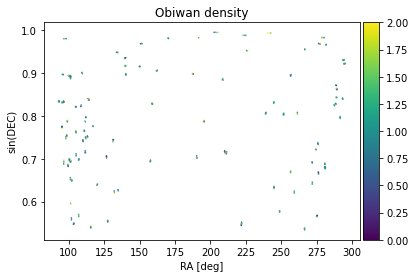

[ 000073.89 ]: 12-09 16:28  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000073.90 ]: 12-09 16:28  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000073.90 ]: 12-09 16:28  HealpixDensity  INFO     Found 379 bricks with randoms.
[ 000073.90 ]: 12-09 16:28  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000074.26 ]: 12-09 16:28  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000074.27 ]: 12-09 16:28  HealpixDensity  INFO     Found 97947 bricks with randoms.
[ 000075.54 ]: 12-09 16:28  Properties      INFO     Calculating EBV statistics.
[ 000075.62 ]: 12-09 16:28  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.0368.
[ 000075.62 ]: 12-09 16:28  Properties      INFO     Calculating EBV statistics.
[ 000075.66 ]: 12-09 16:28  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.1733.
[ 000075.66 ]: 12-09 16:28  Properties      INFO     Calculating GALDEPTH_G statistics.
[ 00

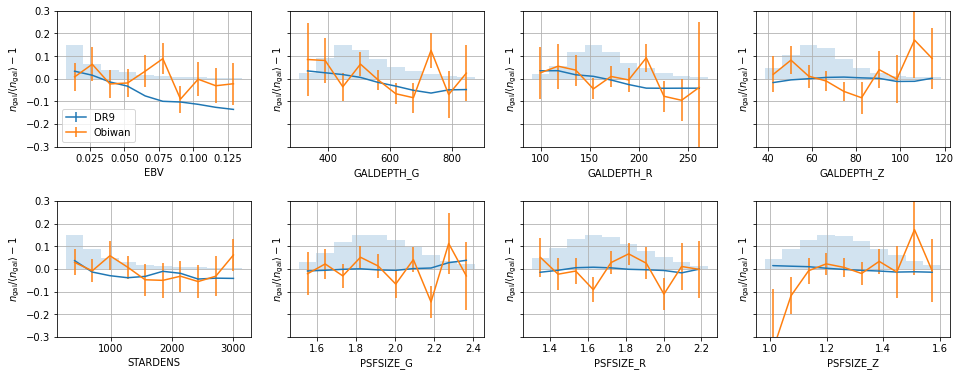

In [4]:
# Density maps
map = Catalogue.load(path_hp)
obiwan_dens = HealpixDensity(map=map)
obiwan_dens.set_randoms(randoms=obiwan_randoms)
obiwan_dens.set_properties()
obiwan_dens.set_data(data=obiwan_data)
obiwan_dens.plot_density_map(title='Obiwan density',vmin=0,vmax=2)

dens = HealpixDensity(map=map)
#obiwan_dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
obiwan_dens.set_randoms(randoms=obiwan_randoms)
obiwan_dens.set_properties()
obiwan_dens.set_data(data=obiwan_data)

dens = HealpixDensity(map=map)
#dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
dens.set_randoms(randoms=randoms)
dens.set_properties()
dens.set_data(data=data)

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] +  ['PSFSIZE_{}'.format(b) for b in data.bands]

others = [obiwan_dens]
labels = ['DR9','Obiwan']

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(16,6))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},xedges={'quantiles':[0.02,0.98]})
plt.show()

## Nothing clear, Obiwan is quite noisy... Let's focus on EBV

[ 000078.83 ]: 12-09 16:28  BinnedStatistic INFO     Using 10 bins.
[ 000079.20 ]: 12-09 16:28  BinnedDensity   INFO     Inferring brickid from randoms.
[ 000079.20 ]: 12-09 16:28  BinnedDensity   INFO     Found 10 bricks with randoms.
[ 000086.35 ]: 12-09 16:28  BinnedStatistic INFO     Using 10 bins.
[ 000086.35 ]: 12-09 16:28  BinnedDensity   INFO     Inferring brickid from randoms.
[ 000086.35 ]: 12-09 16:28  BinnedDensity   INFO     Found 10 bricks with randoms.
[ 000086.39 ]: 12-09 16:28  Properties      INFO     Calculating EFLUX_G statistics.
[ 000086.74 ]: 12-09 16:28  Properties      INFO     Calculating EFLUX_G statistics.
[ 000086.75 ]: 12-09 16:28  Properties      INFO     Calculating EFLUX_G statistics.
[ 000086.75 ]: 12-09 16:28  BinnedDensity   INFO     Fraction of randoms not included in EFLUX_G plot: 0.0000.
[ 000086.75 ]: 12-09 16:28  Properties      INFO     Calculating EFLUX_G statistics.
[ 000086.75 ]: 12-09 16:28  BinnedDensity   INFO     Fraction of randoms not 

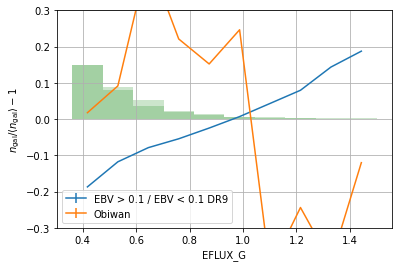

In [5]:
data.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
denslow = BinnedDensity(ref=data,fields=['EFLUX_G'],ranges=(0.36,1.5),nbins=10)
denslow.set_randoms(randoms=data)
denslow.set_data(data=data[data['EBV']<0.1])
denslow.set_properties(weights='data')
denshigh = denslow.deepcopy()
denshigh.set_data(data=data[data['EBV']>0.1])
denshigh.set_properties(weights='data')
densratio = denshigh/denslow

obiwan_data.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
denslow = BinnedDensity(ref=obiwan_data,fields=['EFLUX_G'],ranges=(0.36,1.5),nbins=10)
denslow.set_randoms(randoms=obiwan_data)
denslow.set_data(data=obiwan_data[obiwan_data['EBV']<0.1])
denslow.set_properties(weights='data')
denshigh = denslow.deepcopy()
denshigh.set_data(data=obiwan_data[obiwan_data['EBV']>0.1])
denshigh.set_properties(weights='data')
obiwan_densratio = denshigh/denslow

labels = ['EBV > 0.1 / EBV < 0.1 DR9','Obiwan']
densratio.plot_density_variations(prop='EFLUX_G',others=[obiwan_densratio],histos=[denslow,denshigh],var_kwargs={'errors':False,'labels':labels},histo_kwargs={'colors':['g']*2})

# Redo with gmag cuts only (more stats)

In [6]:
# Obiwan
obiwan.set_estimated_flux(key='SIM_EFLUX',key_transmission='SIM_MW_TRANSMISSION',key_flux='SIM_FLUX')
obiwan.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
mask_tsin = obiwan.mask_maskbit(key_nobs='SIM_NOBS',key_maskbits='SIM_MASKBITS') #& (obiwan['SIM_G'] >= 22.) & (obiwan['SIM_G'] <= 24.)
#mask_tsin[:] = True
for b in obiwan.bands: obiwan[b] = obiwan.mag_from_flux(b,key_flux='EFLUX')
mask_tsout = obiwan.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS') & obiwan['MATCHED'] #& (obiwan['G'] >= 22.) & (obiwan['G'] <= 24.)
#mask_tsout = obiwan['MATCHED']
logger.info('Selecting {:d} (output)/{:d} (input) injected sources.'.format(mask_tsout.sum(),mask_tsin.sum()))
obiwan_data = obiwan[mask_tsout]
obiwan_randoms = obiwan[mask_tsin]

/global/homes/a/adematti/lib/photometry/target_selection.py:92: RuntimeWarning: invalid value encountered in true_divide
  return self['{}_{}'.format(key_flux,b)]/self['{}_{}'.format(key_transmission,b)]
/global/homes/a/adematti/lib/photometry/utils/utils.py:21: RuntimeWarning: divide by zero encountered in log10
  return -2.5*(np.log10(x)-9.)
/global/homes/a/adematti/lib/photometry/utils/utils.py:21: RuntimeWarning: invalid value encountered in log10
  return -2.5*(np.log10(x)-9.)
[ 000086.95 ]: 12-09 16:28  EBV100          INFO     Selecting 25960 (output)/27891 (input) injected sources.


[ 000087.05 ]: 12-09 16:28  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/target/catalogs/dr9m/0.42.0/pixweight/main/resolve/dark/pixweight-dark.fits.
[ 000087.14 ]: 12-09 16:28  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000087.14 ]: 12-09 16:28  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000087.14 ]: 12-09 16:28  HealpixDensity  INFO     Found 483 bricks with randoms.


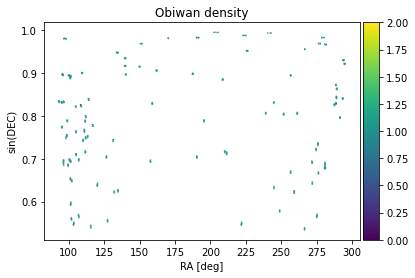

[ 000087.50 ]: 12-09 16:28  Properties      INFO     Calculating EBV statistics.
[ 000087.55 ]: 12-09 16:28  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.1529.
[ 000087.56 ]: 12-09 16:28  Properties      INFO     Calculating GALDEPTH_G statistics.
[ 000087.60 ]: 12-09 16:28  HealpixDensity  INFO     Fraction of randoms not included in GALDEPTH_G plot: 0.1597.
[ 000087.61 ]: 12-09 16:28  Properties      INFO     Calculating GALDEPTH_R statistics.
[ 000087.66 ]: 12-09 16:28  HealpixDensity  INFO     Fraction of randoms not included in GALDEPTH_R plot: 0.1602.
[ 000087.66 ]: 12-09 16:28  Properties      INFO     Calculating GALDEPTH_Z statistics.
[ 000087.71 ]: 12-09 16:28  HealpixDensity  INFO     Fraction of randoms not included in GALDEPTH_Z plot: 0.1588.
[ 000087.71 ]: 12-09 16:28  Properties      INFO     Calculating STARDENS statistics.
[ 000087.75 ]: 12-09 16:28  HealpixDensity  INFO     Fraction of randoms not included in STARDENS plot: 0.1533.
[ 000087

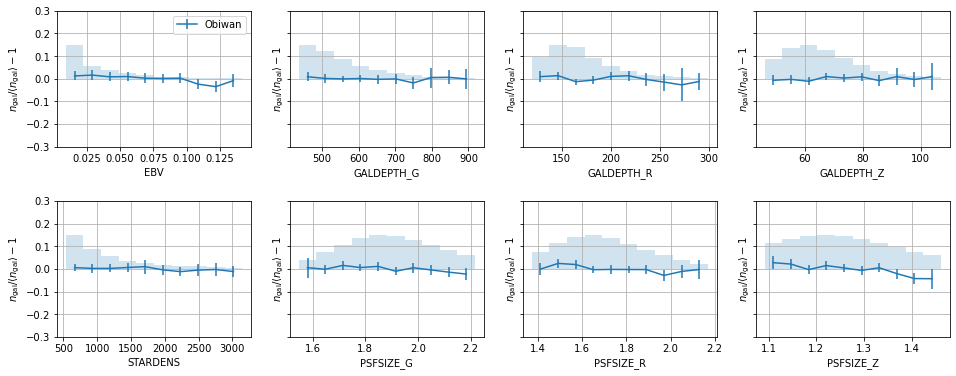

In [7]:
# Density maps
map = Catalogue.load(path_hp)
obiwan_dens = HealpixDensity(map=map)
obiwan_dens.set_randoms(randoms=obiwan_randoms)
obiwan_dens.set_properties()
obiwan_dens.set_data(data=obiwan_data)
obiwan_dens.plot_density_map(title='Obiwan density',vmin=0,vmax=2)

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] + ['PSFSIZE_{}'.format(b) for b in data.bands]

others = []
labels = ['Obiwan']

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(16,6))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    obiwan_dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},xedges={'quantiles':[0.1,0.95]})
    
plt.show()

## No clear trend

# Next, look at flux bias and variance as a function of EBV

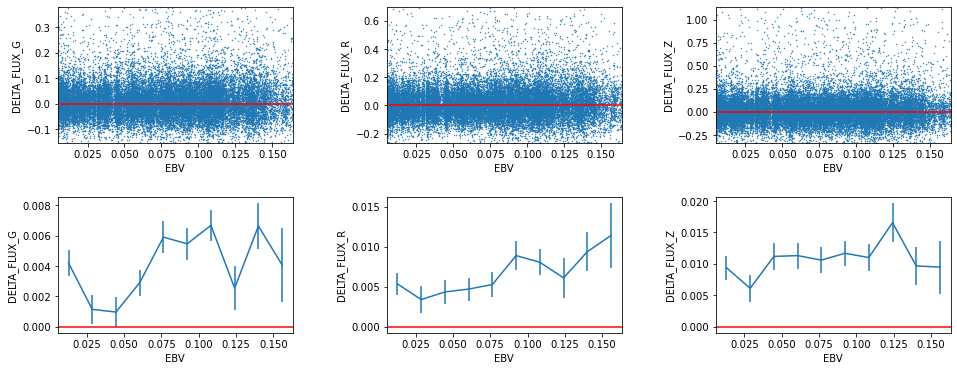

In [8]:
obiwan = obiwan[obiwan['MATCHED']]
from scipy import special,stats
def estimate_std(tab):
        # trick to estimate standard deviation in presence of outliers
        return np.median(np.abs(tab-np.median(tab)))/(2.**0.5*special.erfinv(1./2.))
from photometry.utils import Binning

for xlabel in ['EBV']:
    fig,lax = plt.subplots(ncols=3,nrows=2,sharex=False,sharey=False,figsize=(16,6))
    fig.subplots_adjust(hspace=0.4,wspace=0.4)
    lax = lax.flatten()
    bands = ['G','R','Z']
    for ax,b in zip(lax,bands):
        obiwan['DELTA_FLUX_{}'.format(b)] = (obiwan['FLUX_{}'.format(b)]-obiwan['SIM_FLUX_{}'.format(b)])/obiwan['MW_TRANSMISSION_{}'.format(b)]
        obiwan.plot_scatter(ax,prop1=xlabel,prop2='DELTA_FLUX_{}'.format(b),xedges={'quantiles':[0.01,0.99]},yedges={'quantiles':[0.01,0.99]})
        ax.axhline(y=0,xmin=0,xmax=1,color='r')
    lax = lax[len(bands):]
    for ax,b in zip(lax,bands):
        xedges = Binning(samples=obiwan[xlabel],quantiles=[0.01,0.99]).edges
        x = (xedges[:-1] + xedges[1:])/2.
        y = stats.binned_statistic(obiwan[xlabel],obiwan['DELTA_FLUX_{}'.format(b)],bins=xedges,statistic='median')[0]
        yerr = stats.binned_statistic(obiwan[xlabel],obiwan['DELTA_FLUX_{}'.format(b)],bins=xedges,statistic=estimate_std)[0]
        counts = stats.binned_statistic(obiwan[xlabel],obiwan['DELTA_FLUX_{}'.format(b)],bins=xedges,statistic='count')[0]
        yerr *= 1/counts**0.5
        ax.errorbar(x,y,yerr)
        ax.axhline(y=0,xmin=0,xmax=1,color='r')
        ax.set_ylabel('DELTA_FLUX_{}'.format(b))
        ax.set_xlabel(xlabel)
    plt.show()

## Maybe small trend of Delta flux_r with EBV? Let's look at magnitudes, maybe something will show up

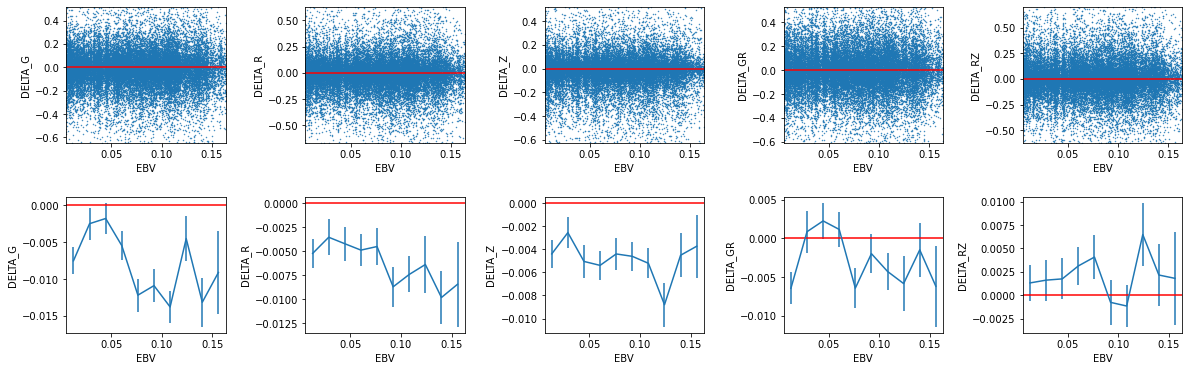

In [9]:
for xlabel in ['EBV']:
    fig,lax = plt.subplots(ncols=5,nrows=2,sharex=False,sharey=False,figsize=(20,6))
    fig.subplots_adjust(hspace=0.4,wspace=0.5)
    lax = lax.flatten()
    bands = ['G','R','Z'] + ['GR','RZ']
    for ax,b in zip(lax,bands):
        if b == 'GR':
            obiwan['DELTA_{}'.format(b)] = obiwan['DELTA_G'] - obiwan['DELTA_R']
        elif b == 'RZ':
            obiwan['DELTA_{}'.format(b)] = obiwan['DELTA_R'] - obiwan['DELTA_Z']
        else:
            obiwan['DELTA_{}'.format(b)] = utils.flux_to_mag(obiwan['FLUX_{}'.format(b)].clip(1e-16)/obiwan['MW_TRANSMISSION_{}'.format(b)])
            obiwan['DELTA_{}'.format(b)] -= utils.flux_to_mag(obiwan['SIM_FLUX_{}'.format(b)].clip(1e-16)/obiwan['SIM_MW_TRANSMISSION_{}'.format(b)])
        obiwan.plot_scatter(ax,prop1=xlabel,prop2='DELTA_{}'.format(b),xedges={'quantiles':[0.01,0.99]},yedges={'quantiles':[0.01,0.99]})
        ax.axhline(y=0,xmin=0,xmax=1,color='r')
    lax = lax[len(bands):]

    for ax,b in zip(lax,bands):
        xedges = Binning(samples=obiwan[xlabel],quantiles=[0.01,0.99]).edges
        x = (xedges[:-1] + xedges[1:])/2.
        y = stats.binned_statistic(obiwan[xlabel],obiwan['DELTA_{}'.format(b)],bins=xedges,statistic='median')[0]
        yerr = stats.binned_statistic(obiwan[xlabel],obiwan['DELTA_{}'.format(b)],bins=xedges,statistic=estimate_std)[0]
        counts = stats.binned_statistic(obiwan[xlabel],obiwan['DELTA_{}'.format(b)],bins=xedges,statistic='count')[0]
        yerr *= 1/counts**0.5
        ax.errorbar(x,y,yerr)
        ax.axhline(y=0,xmin=0,xmax=1,color='r')
        ax.set_ylabel('DELTA_{}'.format(b))
        ax.set_xlabel(xlabel)
    plt.show()

## Again, nothing striking. Let's reproduce what Ashley found with MCTool

[ 000091.03 ]: 12-09 16:28  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.1946.
[ 000091.03 ]: 12-09 16:28  Catalogue       INFO     Loading catalogue /project/projectdirs/desi/users/ajross/MCdata/desi_mcsyst_truth.dr7.34ra38.-7dec-3.fits.
[ 000091.81 ]: 12-09 16:28  TargetSelection INFO     Selecting 549181/549181 targets.


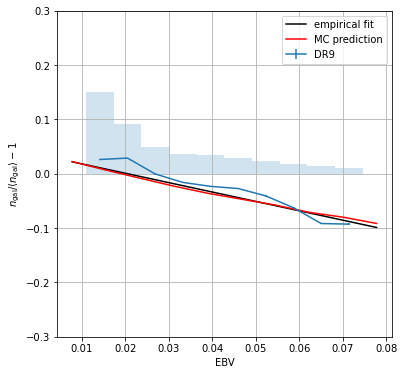

In [10]:
fig,ax = plt.subplots(ncols=1,nrows=1,sharex=False,sharey=False,figsize=(6,6))
dens.plot_density_variations(ax=ax,others=[],prop='EBV',histos=[dens],var_kwargs={'labels':'DR9'},leg_kwargs={},xedges={'quantiles':[0.1,0.9]})
ebv = np.linspace(*ax.get_xlim(),num=10)
model = 1. - .25/.15*ebv # Ashley's fit
norm = 1.04 # just for plotting purposes
model = model/np.mean(model)/norm - 1.

truth = TargetSelection.load_objects(path_truth,tracer='ELG',region=None,case_sensitive=False)
truth.set_flux_from_mag(key='FLUX')
truth['REDSHIFT'] = truth['hsc_mizuki_photoz_best']
truth.region = region
mask = np.all([~np.isnan(truth[b]) for b in truth.bands],axis=0)
truth = truth[mask]

# Ashley's prediction, see: https://github.com/desihub/LSS/blob/master/Sandbox/imaging/ELGEBV.ipynb
def predict_additional_transmission(ebv,flux,b):
    transmission = 10.**(-0.4*0.6*TargetSelection.EXT_COEFFS[b]*ebv)
    return transmission + (1.-transmission)*special.erf(2.*flux)

correlation = np.ones((3,3))*.5 #just given them all correlation of 0.5 for now
np.fill_diagonal(correlation,1.)
std = np.array([0.03,0.05,0.1])
flux_covariance = correlation*std*std[:,None]
efficiency = []
for ebv_ in ebv:
    mc = MCTool(truth=truth,seed=42)
    mc.set_sel_params(ebvfac=1,Rv=None,sn_band_min=6,sn_flat_min=None,sn_red_min=None)
    mc.set_sim_params(flux_covariance=flux_covariance,flux_adbias=0.,flux_mulbias=1.)
    mc.sim['EBV'] = ebv_
    mc.sim.set_estimated_transmission(key='EMW_TRANSMISSION')
    mc.sim.set_estimated_transmission(key='MW_TRANSMISSION')
    mc.sim['MW_TRANSMISSION_G'] *= predict_additional_transmission(ebv=mc.sim['EBV'],flux=mc.truth['FLUX_G'],b='G')
    mc()
    efficiency.append(mc.get_efficiency())
efficiency = np.array(efficiency)/np.mean(efficiency)/norm - 1.

ax.plot(ebv,model,label='empirical fit',color='k')
ax.plot(ebv,efficiency,label='MC prediction',color='r')
ax.legend()
plt.show()

## Let's compare Ashley's predicted flux multiplicative bias (EBV, FLUX_G) with Obiwan measurements

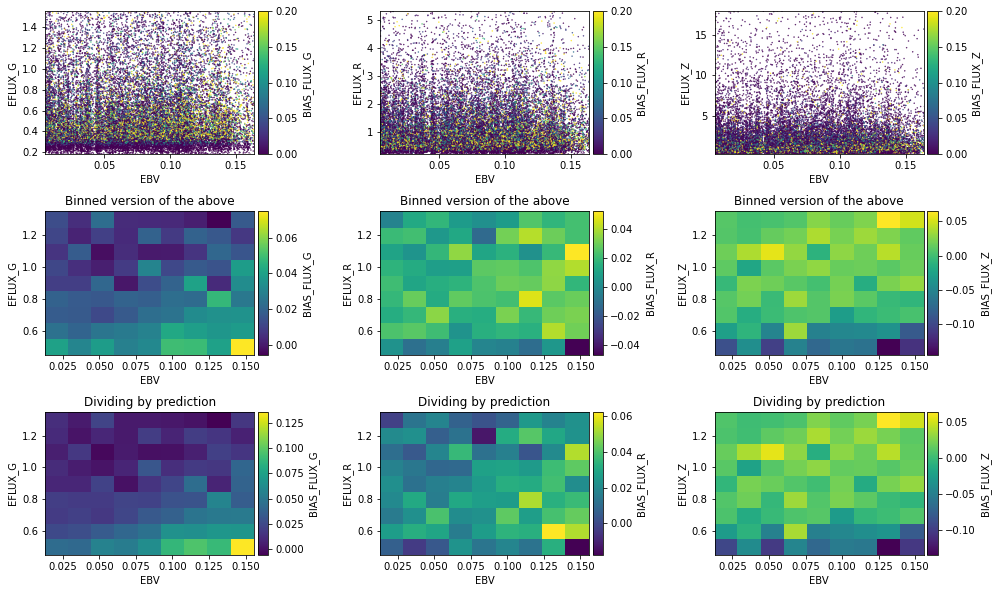

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

obiwan.set_estimated_flux(key='SIM_EFLUX',key_transmission='SIM_MW_TRANSMISSION',key_flux='SIM_FLUX')
obiwan.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
for xlabel in ['EBV']:
    fig,lax = plt.subplots(ncols=3,nrows=3,sharex=False,sharey=False,figsize=(16,10))
    fig.subplots_adjust(hspace=0.4,wspace=0.5)
    lax = lax.flatten()
    bands = ['G','R','Z']
    for ax,b in zip(lax,bands):
        obiwan['BIAS_FLUX_{}'.format(b)] = obiwan['EFLUX_{}'.format(b)]/obiwan['SIM_EFLUX_{}'.format(b)]-1.
        obiwan.plot_scatter(ax,prop1=xlabel,prop2='EFLUX_{}'.format(b),propc='BIAS_FLUX_{}'.format(b),vmin=0.,vmax=0.2,clabel='BIAS_FLUX_{}'.format(b),xedges={'quantiles':[0.01,0.99]},yedges={'quantiles':[0.01,0.99]})
    lax = lax[len(bands):]
    for ax,b in zip(lax,bands):
        xedges = Binning(samples=obiwan[xlabel],quantiles=[0.01,0.99]).edges
        yedges = Binning(samples=obiwan['EFLUX_{}'.format(b)],range=[0.4,1.4]).edges
        x = (xedges[:-1] + xedges[1:])/2.
        y = (yedges[:-1] + yedges[1:])/2.
        values = obiwan['BIAS_FLUX_{}'.format(b)]
        z = stats.binned_statistic_2d(obiwan[xlabel],obiwan['EFLUX_{}'.format(b)],values=values,bins=[xedges,yedges],statistic='median')[0]
        im = ax.pcolormesh(x,y,z.T)
        ax.set_ylabel('EFLUX_{}'.format(b))
        ax.set_xlabel(xlabel)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right',size='5%',pad=0.05)
        cbar = plt.colorbar(im,cax=cax)
        cbar.set_label('BIAS_FLUX_{}'.format(b),rotation=90)
        ax.set_title('Binned version of the above')
    
    lax = lax[len(bands):]
    def predict_additional_transmission(ebv,eflux,b):
        transmission = 10.**(-0.4*0.6*TargetSelection.EXT_COEFFS[b]*ebv)
        return transmission + (1.-transmission)*special.erf(2.*eflux)
    for ax,b in zip(lax,bands):
        xedges = Binning(samples=obiwan[xlabel],quantiles=[0.01,0.99]).edges
        yedges = Binning(samples=obiwan['EFLUX_{}'.format(b)],range=[0.4,1.4]).edges
        x = (xedges[:-1] + xedges[1:])/2.
        y = (yedges[:-1] + yedges[1:])/2.
        values = obiwan['EFLUX_{}'.format(b)]/obiwan['SIM_EFLUX_{}'.format(b)]/predict_additional_transmission(obiwan['EBV'],obiwan['SIM_EFLUX_{}'.format(b)],b)-1.
        z = stats.binned_statistic_2d(obiwan[xlabel],obiwan['EFLUX_{}'.format(b)],values=values,bins=[xedges,yedges],statistic='median')[0]
        im = ax.pcolormesh(x,y,z.T)
        ax.set_ylabel('EFLUX_{}'.format(b))
        ax.set_xlabel(xlabel)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right',size='5%',pad=0.05)
        cbar = plt.colorbar(im,cax=cax)
        cbar.set_label('BIAS_FLUX_{}'.format(b),rotation=90)
        ax.set_title('Dividing by prediction')
    
    plt.show()

## More BIAS_FLUX_G variations after dividing by prediction: Obiwan measurements look opposite to Ashley's prediction :(

## Let's prepare next run

In [12]:
# Obiwan
obiwan = TargetSelection.load_objects(path_obiwan,radecbox=None,tracer='ELG',region=None)
obiwan.set_upper_case()
obiwan['MATCHED'] = obiwan['BRICKNAME'] != ''
logger.info('Found {:d}/{:d} matches.'.format(obiwan['MATCHED'].sum(),obiwan.size))
obiwan = obiwan[obiwan['MATCHED']]
obiwan.set_estimated_flux(key='SIM_EFLUX',key_transmission='SIM_MW_TRANSMISSION',key_flux='SIM_FLUX')
obiwan.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')

def isELG_colors(gflux=None, rflux=None, zflux=None, south=True, gmarg=0., grmarg=0., rzmarg=0., primary=None):
    """
    Apply ELG selection with box enlarged by ``gmarg``, ``grmarg``, ``rzmarg``.

    Base selection from https://github.com/desihub/desitarget/blob/master/py/desitarget/cuts.py.
    """
    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    elg = primary.copy()

    # ADM work in magnitudes instead of fluxes. NOTE THIS IS ONLY OK AS
    # ADM the snr masking in ALL OF g, r AND z ENSURES positive fluxes.
    g = 22.5 - 2.5*np.log10(gflux.clip(1e-16))
    r = 22.5 - 2.5*np.log10(rflux.clip(1e-16))
    z = 22.5 - 2.5*np.log10(zflux.clip(1e-16))

    # ADM cuts shared by the northern and southern selections.
    elg &= g > 20 - gmarg                          # bright cut.
    elg &= r - z > 0.3 - rzmarg                    # blue cut.
    elg &= r - z < 1.6 + rzmarg                    # red cut.
    elg &= g - r < -1.2*(r - z) + 1.6 + grmarg     # OII flux cut.

    # ADM cuts that are unique to the north or south.
    if south:
        elg &= g < 23.5 + gmarg # faint cut.
        # ADM south has the FDR cut to remove stars and low-z galaxies.
        elg &= g - r < 1.15*(r - z) - 0.15 + grmarg
    else:
        elg &= g < 23.6 + gmarg # faint cut.
        elg &= g - r < 1.15*(r - z) - 0.35 + grmarg # remove stars and low-z galaxies.

    return elg

def mask_ts(obiwan):
    #return obiwan.mask_ts(key_flux='EFLUX',region=region)
    return isELG_colors(gflux=obiwan['EFLUX_G'],rflux=obiwan['EFLUX_R'],zflux=obiwan['EFLUX_Z'],
                                                south=region=='S',gmarg=0.6,grmarg=0.6,rzmarg=0.6,primary=None)

mask_tsin = obiwan.mask_ts(key_flux='SIM_EFLUX',region=region)
mask_outside = mask_tsin & ~mask_ts(obiwan)
logger.info('{:d}/{:d} = {:.4f} objects outside TS box.'.format(mask_outside.sum(),mask_tsin.sum(),mask_outside.sum()/mask_tsin.sum()))

[ 000097.28 ]: 12-09 16:28  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/adematti/Obiwan/dr9/ebv100/randoms/randoms_full_matched_input.fits.
[ 000098.73 ]: 12-09 16:28  TargetSelection INFO     Selecting 30467/30467 targets.
[ 000098.81 ]: 12-09 16:28  EBV100          INFO     Found 27661/30467 matches.
[ 000098.85 ]: 12-09 16:28  EBV100          INFO     64/2463 = 0.0260 objects outside TS box.


## Miscellaneous

[ 000313.99 ]: 12-09 16:32  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/adematti/Obiwan/dr9/ebv100/randoms/randoms_full_matched_input.fits.
[ 000314.12 ]: 12-09 16:32  TargetSelection INFO     Selecting 30467/30467 targets.
[ 000314.22 ]: 12-09 16:32  EBV100          INFO     Found 27661/30467 matches.


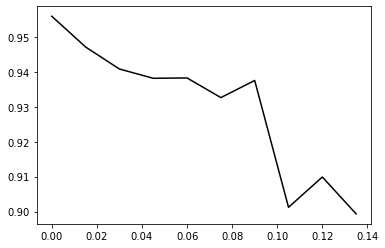

In [16]:
obiwan = TargetSelection.load_objects(path_obiwan,radecbox=None,tracer='ELG',region=None)
obiwan.set_upper_case()
obiwan['MATCHED'] = obiwan['BRICKNAME'] != ''
logger.info('Found {:d}/{:d} matches.'.format(obiwan['MATCHED'].sum(),obiwan.size))

mask_o = obiwan.mask_maskbit(key_nobs='SIM_NOBS',key_maskbits='SIM_MASKBITS') & obiwan['MATCHED']
mask_i = obiwan.mask_maskbit(key_nobs='SIM_NOBS',key_maskbits='SIM_MASKBITS')
#mask_o = obiwan['MATCHED']
#mask_i = obiwan.trues()
"""
for b in ['G','R','Z']:
    mask = obiwan['NOBS_%s' % b] != 0
    plt.scatter(obiwan['EBV'][mask],obiwan['NOBS_%s' % b][mask] - obiwan['SIM_NOBS_%s' % b][mask])
    plt.show()
"""
oh = plt.hist(obiwan['SIM_EBV'][mask_o],range=(0,.15),bins=10)
ih = plt.hist(obiwan['SIM_EBV'][mask_i],range=(0,.15),bins=10)
plt.clf()
plt.plot(oh[1][:-1],oh[0]/ih[0],'k-')
plt.show()

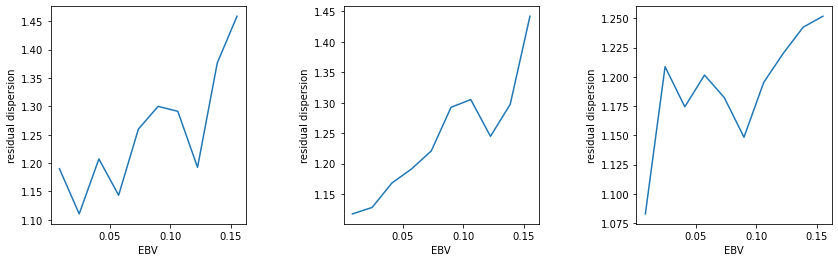

In [18]:
for xlabel in ['EBV']:
    fig,lax = plt.subplots(ncols=3,nrows=1,sharex=False,sharey=False,figsize=(14,4))
    fig.subplots_adjust(hspace=0.4,wspace=0.5)
    lax = lax.flatten()
    bands = ['G','R','Z']
    for ax,b in zip(lax,bands):
        xedges = Binning(samples=obiwan[xlabel],quantiles=[0.01,0.99]).edges
        x = (xedges[:-1] + xedges[1:])/2.
        obiwan['DELTAREL_FLUX_{}'.format(b)] = (obiwan['FLUX_{}'.format(b)] - obiwan['SIM_FLUX_{}'.format(b)])*obiwan['FLUX_IVAR_{}'.format(b)]**0.5
        mask = obiwan['MATCHED']
        yerr = stats.binned_statistic(obiwan[xlabel][mask],obiwan['DELTAREL_FLUX_{}'.format(b)][mask],bins=xedges,statistic=estimate_std)[0]
        ax.plot(x,yerr)
        ax.set_ylabel('residual dispersion')
        ax.set_xlabel(xlabel)
    plt.show()